# Imports

In [1]:
# HIDE
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as t_optim
#import skorch
import pickle
from IPython import display
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
#from cont_metrics.density_estimation.pytorch_kde import kde
#from cont_metrics.hgr import hgr_cond
#from cont_metrics.hgr import hgr
import aif360 as aif

from fairness.helpers import load_ICU_data
from fairness.helpers import plot_distributions
from fairness.helpers import *

#from fairlearn.postprocessing import ThresholdOptimizer
#from fairlearn.postprocessing import plot_threshold_optimizer

from fairness.avd_helpers import *

#from aif360.algorithms.postprocessing import *
import aif360
from aif360.datasets import CompasDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
#from comet_ml import Experiment
import tensorflow.compat.v1 as tf
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import LFR

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="colorblind", color_codes=True, context="talk")
sns.set_theme()

tf.disable_eager_execution()

%matplotlib inline

pip install 'aif360[LawSchoolGPA]'
2023-01-06 14:55:29.186113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


# Comparisons

In [25]:
adult = pd.read_csv('../results/adult/test_results_6_jan.csv').rename({'Unnamed: 0': 'index'}, axis=1).set_index('index')\
        [['sex', 'target', 'biased_label', 'adv_pred', 'lfr_pred', 'roc_pred']]

compas = pd.read_csv('../results/compas/test_results.csv').rename({'Unnamed: 0': 'index'}, axis=1).set_index('index')\
        .drop(columns=['target', 'adveq_pred', 'adveq_change', 'eq_eo_pred', 'eq_eo_change'])

dutch = pd.read_csv('../results/dutch/preds_2.csv').rename({'Unnamed: 0': 'index'}, axis=1).set_index('index')\
        .drop(columns=['target', 'eq_pred', 'eq_change'])
dutch.head()

,sex,biased_pred,lfr_pred,adv_pred,roc_pred,adv_change,lfr_change,roc_change
index,,,,,,,,
6235,1,0,0,0,0.0,0,0,0.0
49276,0,0,0,0,0.0,0,0,0.0
7891,0,0,0,0,0.0,0,0,0.0
17572,1,1,1,1,1.0,0,0,0.0
34628,0,0,0,0,0.0,0,0,0.0


In [29]:
adult = adult.assign(
    adv_change = adult.adv_pred - adult.biased_label,
    lfr_change = adult.lfr_pred - adult.biased_label,
    roc_change = adult.roc_pred - adult.biased_label
)

In [30]:
dutch_lfr = len(dutch[dutch.lfr_change!=0]) / len(dutch) * 100
dutch_adv = len(dutch[dutch.adv_change!=0]) / len(dutch) * 100
dutch_roc = len(dutch[dutch.roc_change!=0]) / len(dutch) * 100

In [31]:
adult_lfr = len(adult[adult.lfr_change!=0]) / len(adult) * 100
adult_adv = len(adult[adult.adv_change!=0]) / len(adult) * 100
adult_roc = len(adult[adult.roc_change!=0]) / len(adult) * 100

In [32]:
compas_lfr = len(compas[compas.lfr_change!=0]) / len(compas) * 100
compas_adv = len(compas[compas.adv_change!=0]) / len(compas) * 100
compas_roc = len(compas[compas.roc_change!=0]) / len(compas) * 100

In [47]:
dnum = pd.DataFrame({
    'method': ['LFR', 'Adversarial', 'ROC'],
    'dataset': 'Dutch Census',
    'predictions changed': [dutch_lfr, dutch_adv, dutch_roc]
})

anum = pd.DataFrame({
    'method': ['LFR', 'Adversarial', 'ROC'],
    'dataset': 'Adult',
    'predictions changed': [adult_lfr, adult_adv, adult_roc]
})

cnum = pd.DataFrame({
    'method': ['LFR', 'Adversarial', 'ROC'],
    'dataset': 'Compas',
    'predictions changed': [compas_lfr, compas_adv, compas_roc]
})

In [48]:
pd.concat([dnum, anum, cnum])

,method,dataset,predictions changed
0,LFR,Dutch Census,20.357498
1,Adversarial,Dutch Census,23.730553
2,ROC,Dutch Census,17.242635
0,LFR,Adult,12.237999
1,Adversarial,Adult,10.228041
2,ROC,Adult,12.403958
0,LFR,Compas,18.681319
1,Adversarial,Compas,15.308829
2,ROC,Compas,12.580523


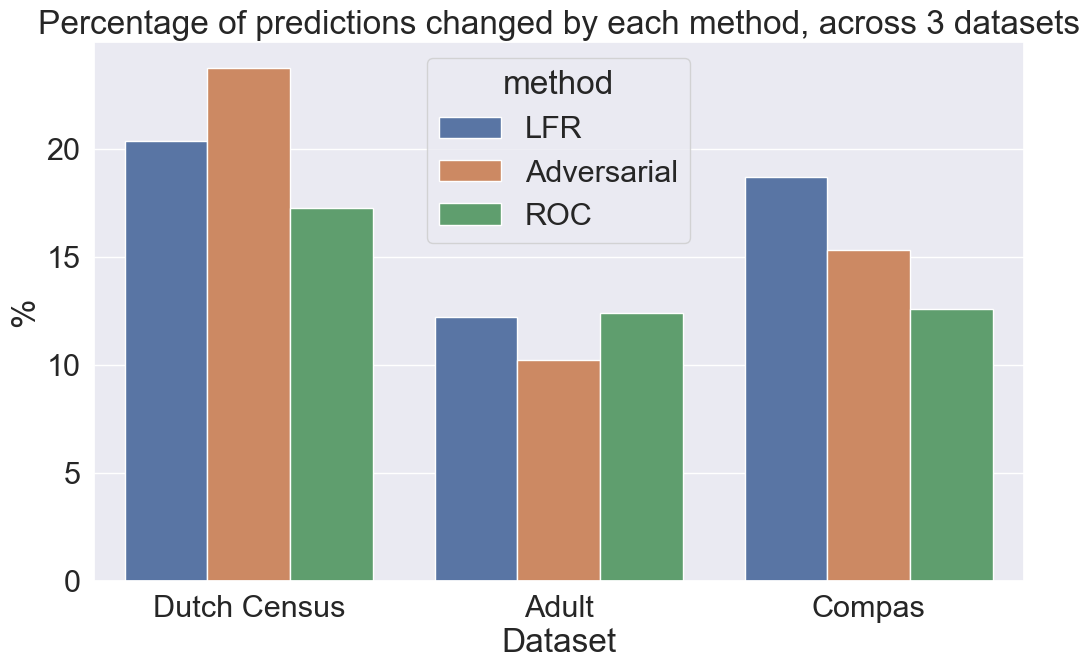

In [70]:
fig, axs = plt.subplots(1,1,figsize=(12,7))

sns.barplot(data=pd.concat([dnum, anum, cnum]), x='dataset', y='predictions changed', hue='method', ax=axs)

axs.set_ylabel('%')
axs.set_xlabel('Dataset')

axs.set_title('Percentage of predictions changed by each method, across 3 datasets')

plt.savefig('../figs/prez/changed_datasets_6_jan.png')

In [50]:
plot_df = pd.concat([dnum, anum, cnum])
plot_df.index = range(len(plot_df))

In [51]:
plot_df

,method,dataset,predictions changed
0,LFR,Dutch Census,20.357498
1,Adversarial,Dutch Census,23.730553
2,ROC,Dutch Census,17.242635
3,LFR,Adult,12.237999
4,Adversarial,Adult,10.228041
5,ROC,Adult,12.403958
6,LFR,Compas,18.681319
7,Adversarial,Compas,15.308829
8,ROC,Compas,12.580523


In [52]:
dutch_inters = len(dutch[(dutch.lfr_change!=0) & (dutch.adv_change!=0) & (dutch.roc_change!=0)]) / len(dutch) * 100
dutch_union = len(dutch[(dutch.lfr_change!=0) | (dutch.adv_change!=0) | (dutch.roc_change!=0)]) / len(dutch) * 100

adult_inters = len(adult[(adult.lfr_change!=0) & (adult.adv_change!=0) & (adult.roc_change!=0)]) / len(adult) * 100
adult_union = len(adult[(adult.lfr_change!=0) | (adult.adv_change!=0) | (adult.roc_change!=0)]) / len(adult) * 100

compas_inters = len(compas[(compas.lfr_change!=0) & (compas.adv_change!=0) & (compas.roc_change!=0)]) / len(compas) * 100
compas_union = len(compas[(compas.lfr_change!=0) | (compas.adv_change!=0) | (compas.roc_change!=0)]) / len(compas) * 100

In [55]:
dutch_inters = len(dutch[(dutch.lfr_change!=0) & (dutch.adv_change!=0) & (dutch.roc_change!=0)])
dutch_union = len(dutch[(dutch.lfr_change!=0) | (dutch.adv_change!=0) | (dutch.roc_change!=0)])

adult_inters = len(adult[(adult.lfr_change!=0) & (adult.adv_change!=0) & (adult.roc_change!=0)])
adult_union = len(adult[(adult.lfr_change!=0) | (adult.adv_change!=0) | (adult.roc_change!=0)])

compas_inters = len(compas[(compas.lfr_change!=0) & (compas.adv_change!=0) & (compas.roc_change!=0)])
compas_union = len(compas[(compas.lfr_change!=0) | (compas.adv_change!=0) | (compas.roc_change!=0)])

dutch_iou = dutch_inters / dutch_union * 100
adult_iou = adult_inters / adult_union * 100
compas_iou = compas_inters / compas_union * 100

In [58]:
print(f'IOU (Dutch) = {dutch_iou:.2f}%')
print(f'IOU (Adult) = {adult_iou:.2f}%')
print(f'IOU (Compas) = {compas_iou:.2f}%')

IOU (Dutch) = 22.92%
IOU (Adult) = 26.48%
IOU (Compas) = 17.89%


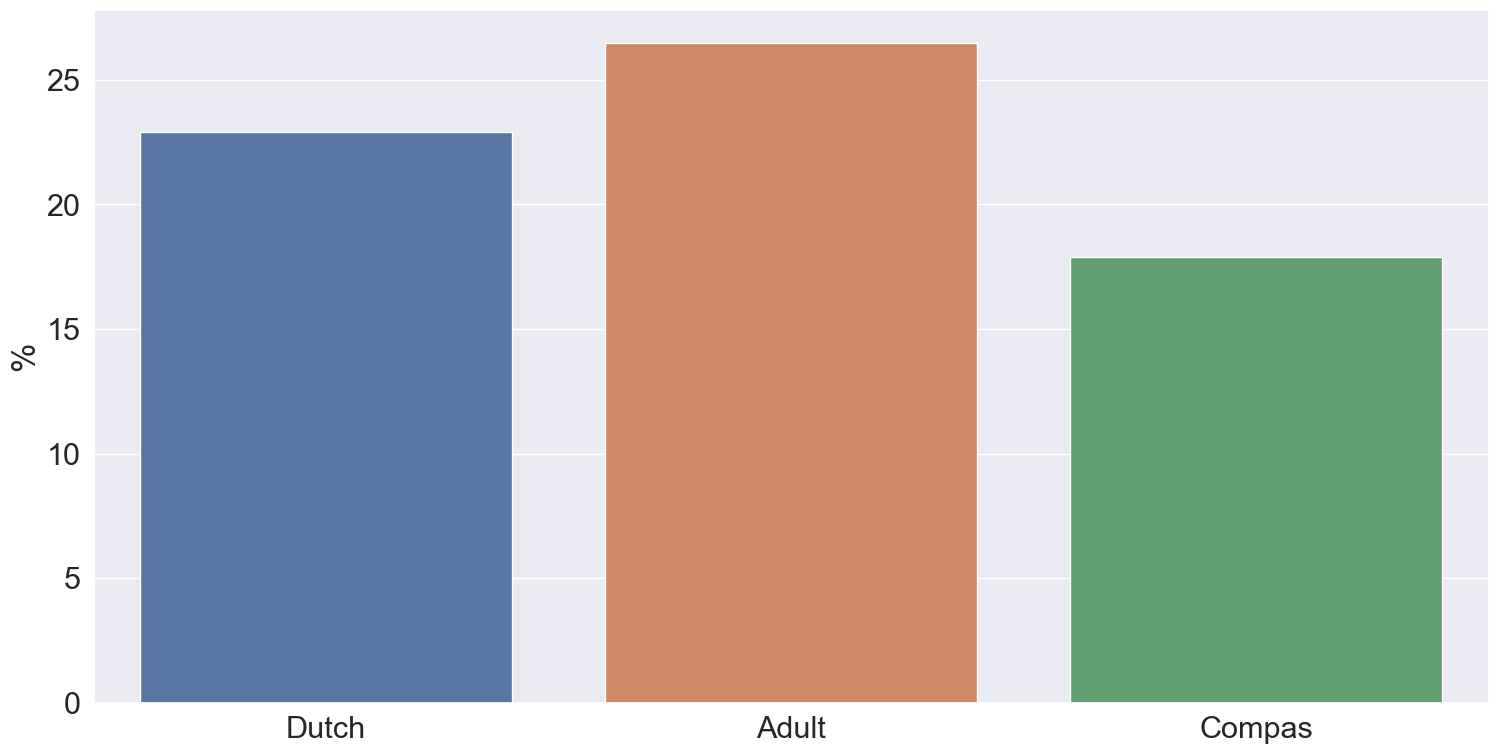

In [69]:
ptdf = pd.DataFrame({
    'Dataset': ['Dutch', 'Adult', 'Compas'],
    'IOU': [dutch_iou, adult_iou, compas_iou]
})

fig, axs = plt.subplots(1,1,figsize=(18,9))

sns.barplot(data=ptdf, x='Dataset', y='IOU', ax=axs)

#plt.setp(axs.get_legend().get_texts(), fontsize='18') # for legend text


axs.set_ylabel('%')
axs.set_xlabel('')

axs.set_title('')
plt.savefig('../figs/prez/IOUs.png')

In [53]:
pltdf = pd.DataFrame({
    'method': ['All methods', '≥ 1 method']*3,
    'dataset': ['Dutch Census', 'Dutch Census', 'Adult', 'Adult', 'Compas', 'Compas'],
    'predictions changed': [dutch_inters, dutch_union, adult_inters, adult_union, compas_inters, compas_union]
})

In [54]:
plt_df = pd.concat([plot_df, pltdf]).sort_values(['dataset'])
plt_df

,method,dataset,predictions changed
3,LFR,Adult,12.237999
4,Adversarial,Adult,10.228041
5,ROC,Adult,12.403958
2,All methods,Adult,4.966501
3,≥ 1 method,Adult,18.753457
6,LFR,Compas,18.681319
7,Adversarial,Compas,15.308829
8,ROC,Compas,12.580523
4,All methods,Compas,4.433498
5,≥ 1 method,Compas,24.782114


In [68]:
sns.set(font_scale = 2)


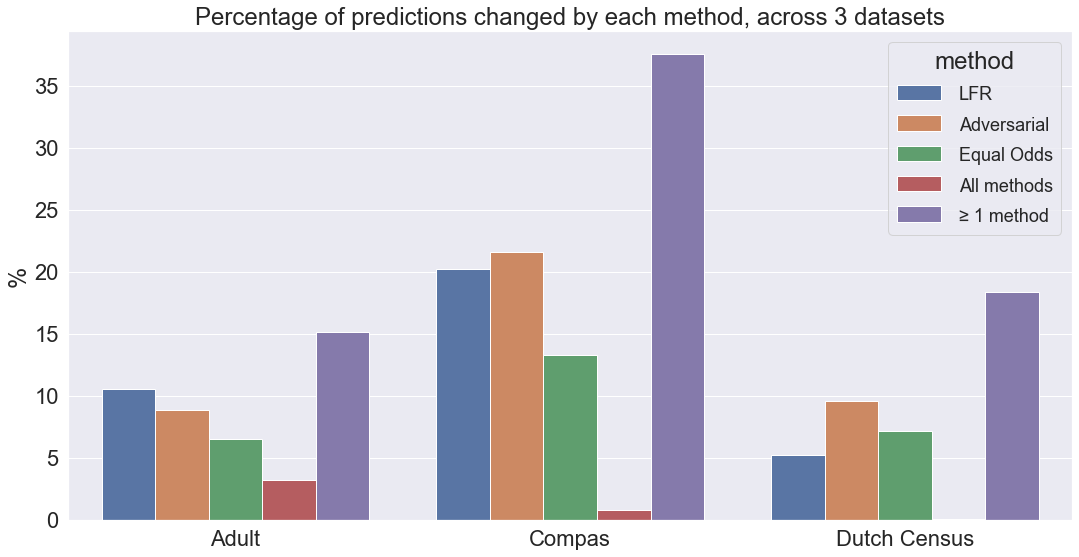

In [134]:
fig, axs = plt.subplots(1,1,figsize=(18,9))

sns.barplot(data=plt_df, x='dataset', y='predictions changed', hue='method', ax=axs)

plt.setp(axs.get_legend().get_texts(), fontsize='18') # for legend text


axs.set_ylabel('%')
axs.set_xlabel('')

axs.set_title('Percentage of predictions changed by each method, across 3 datasets')
plt.savefig('../figs/prez/changes_overall.png')

In [136]:
adult.head()

,sex,biased_pred,adv_pred,lfr_pred,eq_pred,adv_change,lfr_change,eq_change
index,,,,,,,,
258,Female,0,0.0,0,0,0.0,0,0
26976,Female,0,0.0,0,0,0.0,0,0
9335,Male,0,0.0,0,0,0.0,0,0
5764,Male,1,1.0,1,1,0.0,0,0
28351,Female,0,0.0,0,0,0.0,0,0


In [150]:
adult_adv = adult.groupby(['sex', 'adv_change']).count()[['biased_pred']].rename({'biased_pred':'count'}, axis=1).reset_index()
adult_adv_useless = adult_adv[((adult_adv.sex=='Female') & (adult_adv.adv_change==-1.0)) | ((adult_adv.sex=='Male') & (adult_adv.adv_change==1.0))].sum()[['count']].item()

In [151]:
adult_lfr = adult.groupby(['sex', 'lfr_change']).count()[['biased_pred']].rename({'biased_pred':'count'}, axis=1).reset_index()
adult_lfr_useless = adult_lfr[((adult_lfr.sex=='Female') & (adult_lfr.lfr_change==-1.0)) | ((adult_lfr.sex=='Male') & (adult_lfr.lfr_change==1.0))].sum()[['count']].item()

In [152]:
adult_eq = adult.groupby(['sex', 'eq_change']).count()[['biased_pred']].rename({'biased_pred':'count'}, axis=1).reset_index()
adult_eq_useless = adult_eq[((adult_eq.sex=='Female') & (adult_eq.eq_change==-1.0)) |
                             ((adult_eq.sex=='Male') & (adult_eq.eq_change==1.0))].sum()[['count']].item()

<AxesSubplot: xlabel='method', ylabel='percent'>

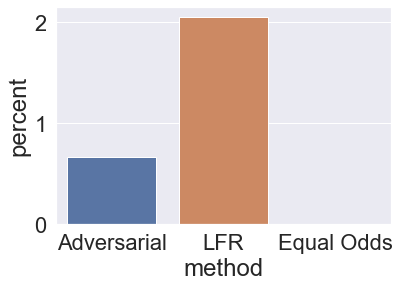

In [162]:
useless_adult = pd.DataFrame({
    'method': ['Adversarial', 'LFR', 'Equal Odds'],
    'percent': [adult_adv_useless/len(adult)*100, adult_lfr_useless/len(adult)*100, adult_eq_useless/len(adult)*100],
    'dataset': 'Adult'
})

sns.barplot(useless_adult, x='method', y='percent')

In [158]:
dutch_adv = dutch.groupby(['sex', 'adv_change']).count()[['biased_pred']].rename({'biased_pred':'count'}, axis=1).reset_index()

dutch_adv_useless = dutch_adv[((dutch_adv.sex==0) & (dutch_adv.adv_change==-1.0)) |
                              ((dutch_adv.sex==1) & (dutch_adv.adv_change==1.0))].sum()[['count']].item()

In [159]:
dutch_lfr = dutch.groupby(['sex', 'lfr_change']).count()[['biased_pred']].rename({'biased_pred':'count'}, axis=1).reset_index()

dutch_lfr_useless = dutch_lfr[((dutch_lfr.sex==0) & (dutch_lfr.lfr_change==-1.0)) |
                              ((dutch_lfr.sex==1) & (dutch_lfr.lfr_change==1.0))].sum()[['count']].item()

<AxesSubplot: xlabel='method', ylabel='percent'>

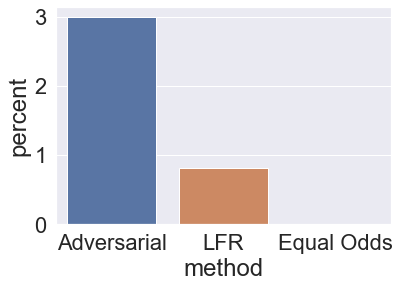

In [163]:
useless_dutch = pd.DataFrame({
    'method': ['Adversarial', 'LFR', 'Equal Odds'],
    'percent': [dutch_adv_useless/len(dutch)*100, dutch_lfr_useless/len(dutch)*100, 0],
    'dataset': 'Dutch'
})

sns.barplot(useless_dutch, x='method', y='percent')

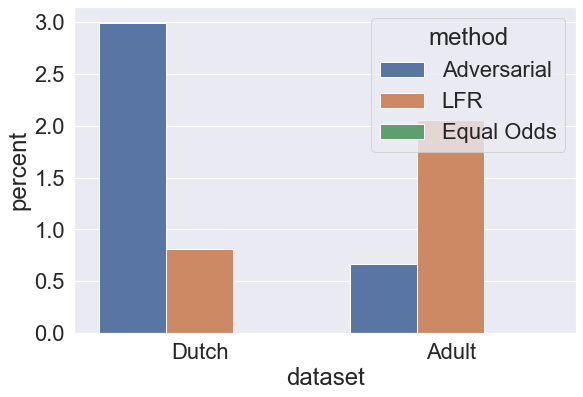

In [168]:
plot_df = pd.concat([useless_dutch, useless_adult])

fig, axs = plt.subplots(1,1,figsize=(9,6))

sns.barplot(data=plot_df, x='dataset', y='percent', hue='method', ax=axs)

plt.savefig('../figs/prez/useless.png')

In [173]:
compas_union = compas[(compas.adv_change!=0) | (compas.lfr_change!=0) | (compas.eq_change!=0)]
compas_intersection = compas[(compas.adv_change!=0) & (compas.lfr_change!=0) & (compas.eq_change!=0)]

In [175]:
len(compas_intersection) / len(compas_union) * 100

2.2222222222222223

In [178]:
len(compas_intersection)

22

In [179]:
len(compas_union)

990

In [180]:
compas.head()

,race,biased_pred,lfr_pred,adv_pred,eq_pred,lfr_change,adv_change,eq_change
index,,,,,,,,
6401,0,0.0,0.0,1.0,0,0.0,1.0,0.0
108,1,1.0,1.0,1.0,1,0.0,0.0,0.0
6770,1,1.0,1.0,1.0,1,0.0,0.0,0.0
4968,1,1.0,1.0,1.0,1,0.0,0.0,0.0
890,0,1.0,1.0,1.0,1,0.0,0.0,0.0


In [182]:
compas_df = pd.read_csv('../data/compas/compas-scores-two-years.csv')#[['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'decile_score', 'decile_score.1', 'score_text']]

In [200]:
dd = compas_df[['sex', 'age', 'age_cat', 'race', 'decile_score', 'priors_count', 'score_text', 'c_charge_degree', 'two_year_recid', 'is_recid', 'days_b_screening_arrest',
        'juv_fel_count', 'juv_misd_count']].replace({
    'Greater than 45':'Above_FourtyFive',
    'Less than 25':'Below_TwentyFive',
    '25 - 45': 'Between_25_45',
    'M':'Misdemeanor',
    'F':'Felony'
})#.pipe(pd.get_dummies, drop_first=True)

dd = dd[(dd.days_b_screening_arrest <= 30) & (dd.days_b_screening_arrest >=-30)].drop(columns=['days_b_screening_arrest', 'is_recid', 'two_year_recid', 'age_cat']).assign(score_factor = lambda x: x['score_text'].map(lambda y: 1 if y=='Low' else 0))# .pipe(pd.get_dummies, drop_first=True)#.describe()
dd = dd[(dd.race=='African-American') | (dd.race=='Caucasian')]
dd.head()

,sex,age,race,decile_score,priors_count,score_text,c_charge_degree,juv_fel_count,juv_misd_count,score_factor
1,Male,34,African-American,3,0,Low,Felony,0,0,1
2,Male,24,African-American,4,4,Low,Felony,0,0,1
6,Male,41,Caucasian,6,14,Medium,Felony,0,0,0
8,Female,39,Caucasian,1,0,Low,Misdemeanor,0,0,1
10,Male,27,Caucasian,4,0,Low,Felony,0,0,1


In [201]:
dd = dd.assign(
    race = lambda x: (x['race'] == 'Caucasian')*1,
    sex = lambda x: (x.sex == 'Male')*1,
    felony = lambda x: (x.c_charge_degree == 'Felony')*1
         ).drop(columns = ['score_text', 'c_charge_degree'])

compas_test = dd.loc[compas.index]

In [205]:
compas_t = pd.concat([compas_test, compas.drop(columns=['race'])], axis=1)

In [233]:
a = compas_t[compas_t.lfr_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']].loc[['mean', 'min', 'max']].rename({
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)
a

,Age,Priors,Juvenial Felonies,Juvenial Misdemeanors
mean,28.742056,2.31215,0.0,0.005607
min,19.000000,0.00000,0.0,0.000000
max,71.000000,14.00000,0.0,1.000000


In [234]:
b = compas_t[compas_t.lfr_change!=0].groupby('sex').count()[['age']].rename({0:'Female', 1:'Male'}).rename({'age':'count'}, axis=1)
b

,count
sex,
Female,59
Male,476


In [235]:
c = compas_t[compas_t.lfr_change!=0].groupby('race').count()[['age']].rename({0:'Black', 1:'White'}).rename({'age':'count'}, axis=1)
c

,count
race,
Black,326
White,209


In [236]:
d = compas_t[compas_t.lfr_change!=0].groupby('felony').count()[['age']].rename({'age':'count'}, axis=1)
d

,count
felony,
0,139
1,396


In [238]:
pd.concat([a.reset_index(),b.reset_index(),c.reset_index(),d.reset_index()], axis=1)

,index,Age,Priors,Juvenial Felonies,Juvenial Misdemeanors,sex,count,race,count,felony,count
0,mean,28.742056,2.31215,0.0,0.005607,Female,59.0,Black,326.0,0.0,139.0
1,min,19.000000,0.00000,0.0,0.000000,Male,476.0,White,209.0,1.0,396.0
2,max,71.000000,14.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
compas_t[compas_t.adv_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']].loc[['mean', 'min', 'max']].rename({
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)

,Age,Priors,Juvenial Felonies,Juvenial Misdemeanors
mean,29.389474,3.647368,0.001754,0.019298
min,19.000000,0.000000,0.000000,0.000000
max,69.000000,22.000000,1.000000,1.000000


In [218]:
compas_t[compas_t.adv_change!=0].groupby('sex').count()[['age']].rename({0:'Female', 1:'Male'}).rename({'age':'count'}, axis=1)

,count
sex,
Female,41
Male,529


In [219]:
compas_t[compas_t.adv_change!=0].groupby('race').count()[['age']].rename({0:'Black', 1:'White'}).rename({'age':'count'}, axis=1)

,count
race,
Black,518
White,52


In [223]:
compas_t[compas_t.adv_change!=0].groupby('felony').count()[['age']].rename({'age':'count'}, axis=1)

,count
felony,
0,117
1,453


In [225]:
compas_t[compas_t.eq_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']].loc[['mean', 'min', 'max']].rename({
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)

,Age,Priors,Juvenial Felonies,Juvenial Misdemeanors
mean,40.803977,1.284091,0.0,0.011364
min,20.000000,0.000000,0.0,0.000000
max,73.000000,12.000000,0.0,2.000000


In [228]:
compas_t[compas_t.eq_change!=0].groupby('sex').count()[['age']].rename({0:'Female', 1:'Male'}).rename({'age':'count'}, axis=1)

,count
sex,
Female,57
Male,295


In [230]:
compas_t[compas_t.eq_change!=0].groupby('race').count()[['age']].rename({0:'Black', 1:'White'}).rename({'age':'count'}, axis=1)

,count
race,
Black,1
White,351


In [231]:
compas_t[compas_t.eq_change!=0].groupby('felony').count()[['age']].rename({'age':'count'}, axis=1)

,count
felony,
0,164
1,188


In [245]:
compas.groupby(['race', 'lfr_pred']).count()[['biased_pred']]

biased_pred
race lfr_pred             
0    0.0               628
     1.0               955
1    0.0               480
     1.0               576

In [252]:
print(f'LFR: {955/(628+955) * 100:.2f}% of black people are in the positive class')
print(f'LFR: {576/(576+480) * 100:.2f}% of white people are in the positive class')

LFR: 60.33% of black people are in the positive class
LFR: 54.55% of white people are in the positive class


In [246]:
compas.groupby(['race', 'adv_pred']).count()[['biased_pred']]

biased_pred
race adv_pred             
0    0.0               436
     1.0              1147
1    0.0               321
     1.0               735

In [253]:
print(f'Adversarial: {1147/(1147+436) * 100:.2f}% of black people are in the positive class')
print(f'Adversarial: {735/(735+321) * 100:.2f}% of white people are in the positive class')

Adversarial: 72.46% of black people are in the positive class
Adversarial: 69.60% of white people are in the positive class


In [247]:
compas.groupby(['race', 'eq_pred']).count()[['biased_pred']]

biased_pred
race eq_pred             
0    0                953
     1                630
1    0                622
     1                434

In [254]:
print(f'Equal Odds: {630/(630 + 953) * 100:.2f}% of black people are in the positive class')
print(f'Equal Odds: {434/(434 + 622) * 100:.2f}% of white people are in the positive class')

Equal Odds: 39.80% of black people are in the positive class
Equal Odds: 41.10% of white people are in the positive class


In [255]:
compas.groupby(['race', 'biased_pred']).count()#[['biased_pred']]

lfr_pred  adv_pred  eq_pred  lfr_change  adv_change  \
race biased_pred                                                        
0    0.0               954       954      954         954         954   
     1.0               629       629      629         629         629   
1    0.0               271       271      271         271         271   
     1.0               785       785      785         785         785   

                  eq_change  
race biased_pred             
0    0.0                954  
     1.0                629  
1    0.0                271  
     1.0                785

In [256]:
print(f'Equal Odds: {629/(629 + 954) * 100:.2f}% of black people are in the positive class')
print(f'Equal Odds: {785/(785 + 271) * 100:.2f}% of white people are in the positive class')

Equal Odds: 39.73% of black people are in the positive class
Equal Odds: 74.34% of white people are in the positive class


In [257]:
adult.head()

,sex,biased_pred,adv_pred,lfr_pred,eq_pred,adv_change,lfr_change,eq_change
index,,,,,,,,
258,Female,0,0.0,0,0,0.0,0,0
26976,Female,0,0.0,0,0,0.0,0,0
9335,Male,0,0.0,0,0,0.0,0,0
5764,Male,1,1.0,1,1,0.0,0,0
28351,Female,0,0.0,0,0,0.0,0,0
